In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
import re
from sklearn.linear_model import LogisticRegression
import itertools


# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from scipy.optimize import minimize
from sklearn.metrics import log_loss

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [43]:
def evaluate(classes,y_true,y_pred,normalize):
    print (classification_report(y_true, y_pred))
    print ("roc_auc_score : %f " % metrics.roc_auc_score(y_true, y_pred))
    plot_confusion_matrix(confusion_matrix(y_true,y_pred), classes=class_names,normalize=normalize,
                      title='Confusion matrix')
    plt.show()

In [44]:
data = pd.read_json("data/train.json")
data['year']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%Y'), axis=1).astype(int)
data['month']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%m'), axis=1).astype(int)
data['day']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%d'), axis=1).astype(int)
data['dayofweek']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).weekday(), axis=1).astype(int)
data=data.drop(['unix_timestamp_of_request'], axis=1)
data=data.drop(['request_id'], axis=1)
data=data.drop(['unix_timestamp_of_request_utc'], axis=1)
data=data.drop(['request_text_edit_aware'], axis=1)
data=data.drop(['request_title'], axis=1)
data=data.drop(['requester_subreddits_at_request'], axis=1)
data=data.drop(['requester_username'], axis=1)
data=data.drop(['giver_username_if_known'], axis=1)
data=data.drop(['requester_user_flair'], axis=1)
data=data.drop(['requester_days_since_first_post_on_raop_at_retrieval'], axis=1)
#data=data.drop(['requester_account_age_in_days_at_request'], axis=1)
data=data.drop(['requester_account_age_in_days_at_retrieval'], axis=1)
data=data.drop(['number_of_downvotes_of_request_at_retrieval'], axis=1)
data=data.drop(['number_of_upvotes_of_request_at_retrieval'], axis=1)
data=data.drop(['post_was_edited'], axis=1)
data=data.drop(['request_number_of_comments_at_retrieval'], axis=1)
data=data.drop(['requester_number_of_comments_at_retrieval'], axis=1)
data=data.drop(['requester_number_of_comments_in_raop_at_retrieval'], axis=1)
data=data.drop(['requester_number_of_posts_at_retrieval'], axis=1)
data=data.drop(['requester_number_of_posts_on_raop_at_retrieval'], axis=1)
data=data.drop(['requester_upvotes_minus_downvotes_at_retrieval'], axis=1)
data=data.drop(['requester_upvotes_plus_downvotes_at_retrieval'], axis=1)

In [45]:
data.groupby(['requester_received_pizza']).size()

requester_received_pizza
False    3046
True      994
dtype: int64

In [48]:
# Balance the classes by oversampling the success label

In [46]:
data_fail = data[data['requester_received_pizza'] == 0]
data_success = data[data['requester_received_pizza'] == 1]
data = pd.concat([data_fail, data_success,
                      data_success, data_success], axis = 0)

In [49]:
data.groupby(['requester_received_pizza']).size()

requester_received_pizza
False    3046
True     2982
dtype: int64

In [50]:
from sklearn.model_selection import train_test_split

train_data, dev_data = train_test_split(data, test_size=0.3)
train_labels = train_data["requester_received_pizza"]
dev_labels = dev_data["requester_received_pizza"]
train_data=train_data.drop(['requester_received_pizza'], axis=1)
dev_data=dev_data.drop(['requester_received_pizza'], axis=1)

train_data_text = train_data["request_text"]
train_data=train_data.drop(['request_text'], axis=1)
dev_data_text = dev_data["request_text"]
dev_data=dev_data.drop(['request_text'], axis=1)

print (train_data.shape)
print (train_data_text.shape)
print (dev_data.shape)
print (dev_data_text.shape)

(4219, 13)
(4219,)
(1809, 13)
(1809,)


In [51]:
train_data.head(1)

,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,year,month,day,dayofweek
3682,95.596181,0.0,12,0,5,0,4,48,64,2012,8,1,2


In [52]:
class_names = ['No-Pizza','Pizza']
import string
def better_preprocessor(s):
    if len(s)>1: 
      for char in string.punctuation:
         s = s.replace(char, ' ').lower()
    elif (s.isdigit()):
        s = ' '
    else: s=' '        
    return s

In [53]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def stemming_tokenizer(str_input):
    words = str_input.split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [54]:
vectorizer = TfidfVectorizer(stop_words='english',
                     preprocessor=better_preprocessor
                     #,tokenizer=stemming_tokenizer
                      ,min_df=2, 
                      max_df=0.5, 
                     ngram_range=(1,1)       
                     )
X = vectorizer.fit_transform(train_data_text)
print (len(vectorizer.get_feature_names()))

6741


In [55]:
#Fit Logistic Regression model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,solver='lbfgs',C=0.21,
multi_class='multinomial',class_weight='balanced').fit(X,train_labels)
features=vectorizer.get_feature_names()

In [56]:
from sklearn import metrics

X_dev = vectorizer.transform(dev_data_text)
predicted = clf.predict(X_dev)
f=metrics.f1_score(dev_labels, predicted, average='weighted')
print ('\nF1 Score for Logistic Regression Classifier : %r' % f)


F1 Score for Logistic Regression Classifier : 0.7009699434236988


              precision    recall  f1-score   support

       False       0.69      0.69      0.69       869
        True       0.71      0.71      0.71       940

   micro avg       0.70      0.70      0.70      1809
   macro avg       0.70      0.70      0.70      1809
weighted avg       0.70      0.70      0.70      1809

roc_auc_score : 0.700587 


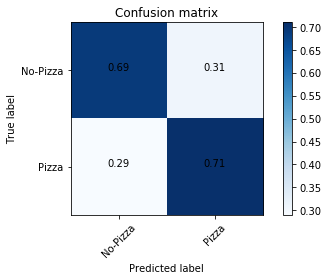

In [57]:
evaluate(class_names,dev_labels,predicted,True)

In [58]:
from sklearn.model_selection import GridSearchCV

param_range=[0.0001,0.0005,0.001]
parameters = {'C': param_range, 'solver':['lbfgs'] }

gs_clf=GridSearchCV(clf, parameters, cv=5, iid=False, n_jobs=-1,scoring='roc_auc')
gs_clf = gs_clf.fit(X, train_labels)

In [59]:
gs_clf.best_params_

{'C': 0.001, 'solver': 'lbfgs'}

In [60]:
y_test=dev_labels

gs_clf = gs_clf.best_estimator_
predicted = gs_clf.predict(X_dev)
f=metrics.f1_score(y_test, predicted, average='weighted')
print ('\nF1 Score for Logistic Regression Classifier : %r' % f)
print('LogLoss : {score}'.format(score=log_loss(y_test, predicted)))


F1 Score for Logistic Regression Classifier : 0.6507253934192468
LogLoss : 12.066742380123518


In [61]:
dev_probs=gs_clf.predict_proba(X_dev)
predicted=[True if dev_probs[k][1] > 0.50 else False for k in range(len(dev_probs))]

              precision    recall  f1-score   support

       False       0.63      0.67      0.65       869
        True       0.67      0.63      0.65       940

   micro avg       0.65      0.65      0.65      1809
   macro avg       0.65      0.65      0.65      1809
weighted avg       0.65      0.65      0.65      1809

roc_auc_score : 0.651314 


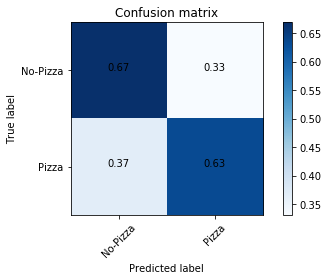

In [62]:
evaluate(class_names,dev_labels,predicted,True)

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

y=train_labels
X=train_data
class_weight='balanced'
rfclf = RandomForestClassifier(n_estimators=300,max_features='sqrt',max_depth=80,min_samples_leaf=1,bootstrap=True,min_samples_split=11,class_weight=class_weight)
rfclf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=80, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=11, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [64]:
X_test=dev_data
y_test=dev_labels
y_pred = rfclf.predict(X_test)
print('Accuracy of classifier on dev set: {:.2f}'.format(rfclf.score(X_test, y_test)))
print('LogLoss : {score}'.format(score=log_loss(y_test, y_pred)))

Accuracy of classifier on dev set: 0.83
LogLoss : 5.9761035621754095


              precision    recall  f1-score   support

       False       0.83      0.81      0.82       869
        True       0.83      0.85      0.84       940

   micro avg       0.83      0.83      0.83      1809
   macro avg       0.83      0.83      0.83      1809
weighted avg       0.83      0.83      0.83      1809

roc_auc_score : 0.826210 


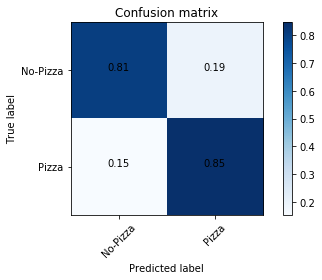

In [65]:
evaluate(class_names,dev_labels,y_pred,True)

In [66]:
predictions=[]
predictions.append(rfclf.predict_proba(X_test))
X_dev = vectorizer.transform(dev_data_text)
predictions.append(gs_clf.predict_proba(X_dev))

In [67]:
dev_probabilities=[int(k) for k in dev_labels]

In [68]:
def log_loss_func(weights):
    final_prediction = 0
    ''' scipy minimize will pass the weights as a numpy array '''
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction

    return log_loss(dev_probabilities, final_prediction)
    #return metrics.recall_score(dev_probabilities, final_prediction)

In [69]:
starting_values = [0.5]*len(predictions)

cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
#our weights are bound between 0 and 1
bounds = [(0,1)]*len(predictions)

res = minimize(log_loss_func, starting_values, method='SLSQP', bounds=bounds, constraints=cons)

print('Ensemble Score: {best_score}'.format(best_score=res['fun']))
print('Best Weights: {weights}'.format(weights=res['x']))

Ensemble Score: 0.47784897623252226
Best Weights: [1.00000000e+00 5.55111512e-17]


In [70]:
weights=res['x']
#weights=starting_values
y_pred=[weights[0]*predictions[0][k][1]+weights[1]*predictions[1][k][1] for k in range(len(dev_data))]
y_pred=[True if k > 0.52 else False for k in y_pred]

              precision    recall  f1-score   support

       False       0.82      0.84      0.83       869
        True       0.85      0.83      0.84       940

   micro avg       0.83      0.83      0.83      1809
   macro avg       0.83      0.83      0.83      1809
weighted avg       0.83      0.83      0.83      1809

roc_auc_score : 0.833853 


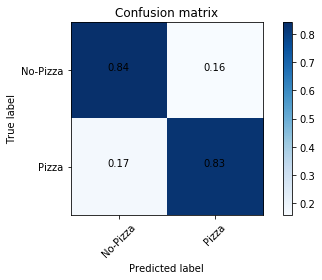

In [71]:
evaluate(class_names,dev_labels,y_pred,True)

## Kaggle Submission

In [146]:
data = pd.read_json("data/test.json")
data['year']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%Y'), axis=1).astype(int)
data['month']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%m'), axis=1).astype(int)
data['day']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%d'), axis=1).astype(int)
data['dayofweek']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).weekday(), axis=1).astype(int)
data=data.drop(['unix_timestamp_of_request'], axis=1)
test_requests_id=data['request_id']
data=data.drop(['request_id'], axis=1)
data=data.drop(['unix_timestamp_of_request_utc'], axis=1)
#data=data.drop(['request_text_edit_aware'], axis=1)
data=data.drop(['request_title'], axis=1)
data=data.drop(['requester_subreddits_at_request'], axis=1)
data=data.drop(['requester_username'], axis=1)
data=data.drop(['giver_username_if_known'], axis=1)

In [147]:
data.requester_days_since_first_post_on_raop_at_request=data.requester_days_since_first_post_on_raop_at_request.astype(int)

In [148]:
data.shape

(1631, 14)

In [149]:
test_data_text = data["request_text_edit_aware"]
test_data=data.drop(['request_text_edit_aware'], axis=1)

In [150]:
predictions=[]
predictions.append(rfclf.predict_proba(test_data))
X_test = vectorizer.transform(test_data_text)
predictions.append(gs_clf.predict_proba(X_test))

In [151]:
weights=res['x']
#weights=starting_values
y_pred=[weights[0]*predictions[0][k][1]+weights[1]*predictions[1][k][1] for k in range(len(test_data))]
y_pred=[True if k > 0.52 else False for k in y_pred]

In [152]:
x = np.array(y_pred).reshape(-1,1)
final_df = pd.DataFrame.from_records(x,columns=['requester_received_pizza'])

In [153]:
final_df=final_df.join(test_requests_id)
cols = final_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
final_df = final_df[cols]
final_df.requester_received_pizza=final_df.requester_received_pizza.astype(int)

In [154]:
final_df.groupby(['requester_received_pizza']).size()

requester_received_pizza
0    1297
1     334
dtype: int64

In [155]:
final_df.head(1)

,request_id,requester_received_pizza
0,t3_i8iy4,1


In [156]:
final_df.to_csv('/tmp/final_submission.csv',header=True,index=False)